Name: Baibhav Shrestha
Student ID: 20411721
Kaggle ID: https://www.kaggle.com/baibhavvv
Kaggle Submission Name: Baibhav

Importing the required libraries

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor

In [6]:
Function to preprocess data. Here, the code removes duplicate values, deal with skewed data,
deal with outliers, fill in missing columns using knn imputer, removing rows with missing values.

SyntaxError: invalid syntax (3046525193.py, line 1)

In [8]:
# Function for data preprocessing
def preprocess_data(df, is_train=True, imputer=None, scaler=None, qt=None, feature_transformer=None):
    # Strip any leading or trailing whitespace characters from the column names and replace spaces with underscores
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    
    # Copy the ID column for later use before any modifications
    IDs = df['ID'].copy()
    
    # Remove duplicate entries based on the ID column, keeping the first occurrence
    df = df.drop_duplicates(subset='ID', keep='first')
    
    # Filter out rows that have more than 5 missing values
    df = df[df.isnull().sum(axis=1) <= 5]

    # Check if the target column 'Target_Pressure_(bar)' exists and select it
    target_column = 'Target_Pressure_(bar)' if 'Target_Pressure_(bar)' in df.columns else None
    df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns for processing used for feature selection
    
    # If the target column exists, separate it from the feature columns
    if target_column and target_column in df_numeric.columns:
        y = df_numeric.pop(target_column).values  # Extract the target values

    # If processing training data, fit the transformers; if not, apply the fitted transformers
    if is_train:
        imputer = KNNImputer(n_neighbors=5)  # Imputer for filling missing values
        scaler = RobustScaler()  # RobustScaler to handle outliers and scale features
        #scaler = StandardScaler()
        qt = QuantileTransformer(output_distribution='normal', random_state=42)  # Normalize target variable distribution
        feature_transformer = PowerTransformer(method='yeo-johnson')  # Reduce skewness in feature variables

        # Transform features to reduce skewness
        df_numeric = pd.DataFrame(feature_transformer.fit_transform(df_numeric), columns=df_numeric.columns)
        
        # Transform the target variable to a normal distribution
        y_transformed = qt.fit_transform(y.reshape(-1, 1)).ravel()
        
        # Scale and impute the feature data
        transformed_data = scaler.fit_transform(imputer.fit_transform(df_numeric))
        
        # Return the transformed data, transformed target, IDs, and the fitted transformers
        return transformed_data, y_transformed, IDs, imputer, scaler, qt, feature_transformer
    else:
        # Apply the same transformations to test data using already fitted transformers
        df_numeric = pd.DataFrame(feature_transformer.transform(df_numeric), columns=df_numeric.columns)
        transformed_data = scaler.transform(imputer.transform(df_numeric))
        
        # Return the transformed data and IDs for test data
        return transformed_data, IDs

In [ ]:
Loading and processing the data into the program.

In [9]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Process data
train_processed, y_train, train_ids, imputer, scaler, qt, feature_transformer = preprocess_data(train_data, is_train=True)
test_processed, test_ids = preprocess_data(test_data, is_train=False, imputer=imputer, scaler=scaler, feature_transformer=feature_transformer)

Splitting the preprocessed training data into training(80%) and validation set(20%)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_processed, y_train, test_size=0.2, random_state=42)


Visualizing the features in a histogram to check for skewness of data
(Also dropping the IDs as it doesnt make sense to visualize IDs to check for skewness of data)

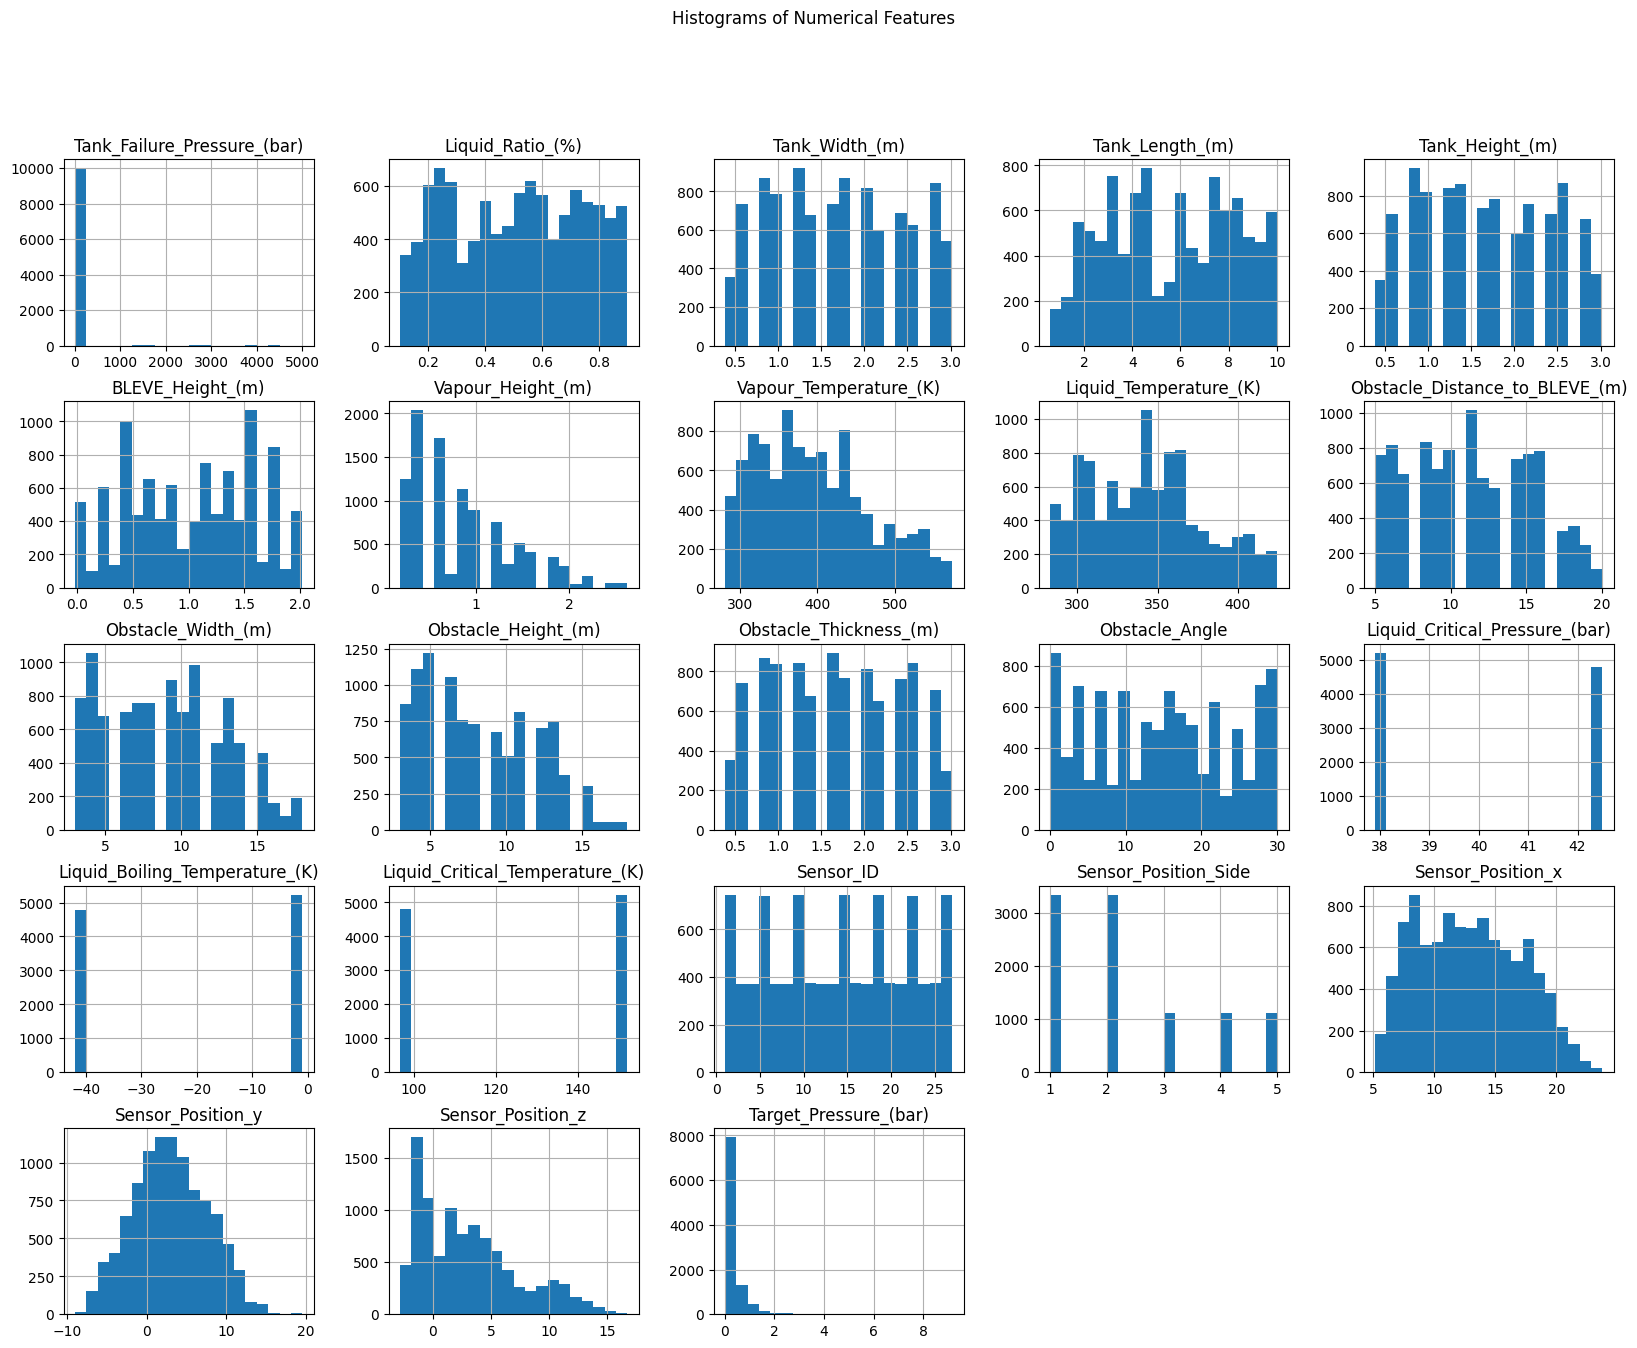

In [10]:
# Select only numerical features excluding 'ID'
numerical_features = train_data.select_dtypes(include=[np.number]).drop('ID', axis=1)

# Histograms for each numerical feature
numerical_features.hist(figsize=(20, 15), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()


Visualizing the outliers in the training set
(Dropping IDs as it doesnt have impact on the outliers)

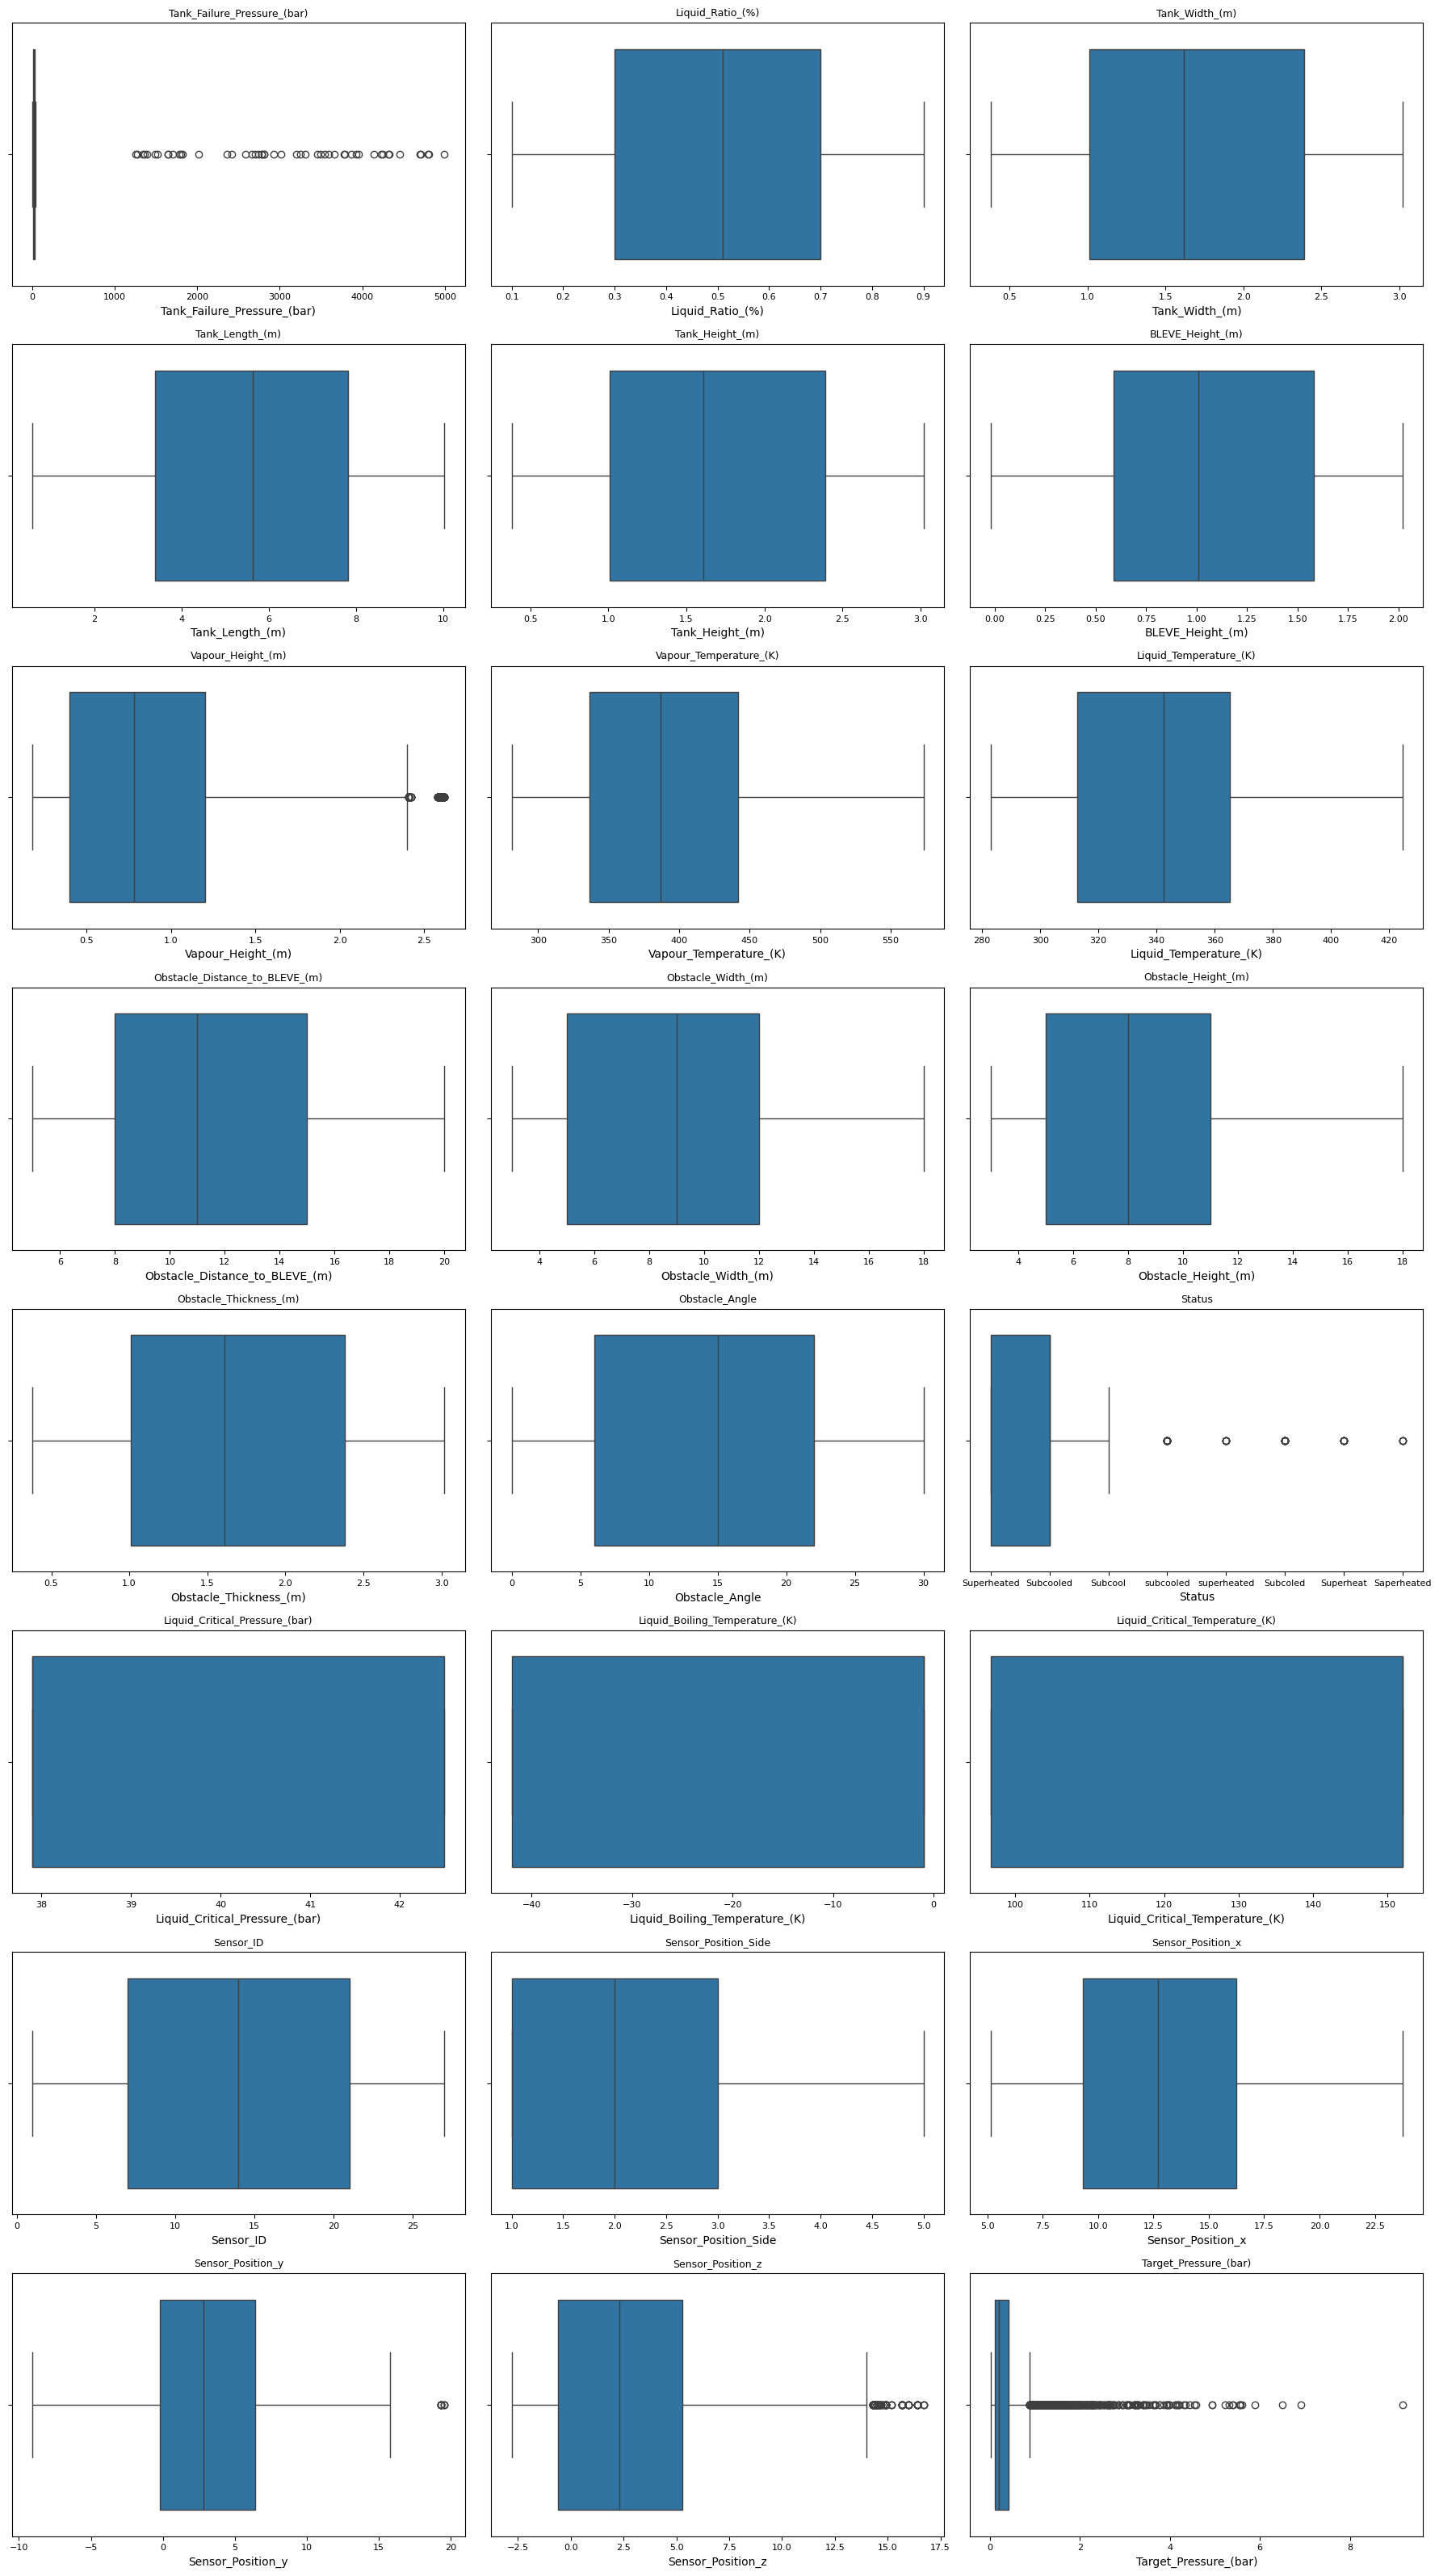

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude 'ID' from the DataFrame if it is not useful for the analysis
data_for_boxplot = train_data.drop('ID', axis=1)

# Calculate the number of rows needed for subplots based on the number of numerical columns
num_columns = data_for_boxplot.select_dtypes(include=[np.number]).shape[1]
num_rows = (num_columns + 2) // 3  # Adjusting for three columns per row

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop over the numerical features and create a boxplot for each
for i, col in enumerate(data_for_boxplot.columns):
    sns.boxplot(x=data_for_boxplot[col], ax=axes[i])
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Since ResNet is used for image processing and not for tabular data, making changes to the ResNet so that it accepts tabular data to make predictions.

In [11]:
# PyTorch model for tabular data with residual connections
class ResNetTabular(nn.Module):
    def __init__(self, num_features, num_blocks=3, hidden_size=64):
        super(ResNetTabular, self).__init__()
        #Initializing a list to hold the blocks of the network
        self.blocks = nn.ModuleList()
        self.final = nn.Linear(num_features, 1)  # Final layer for regression
        #Creating the blocks of the network
        for _ in range(num_blocks):
            self.blocks.append(nn.Sequential(
                nn.Linear(num_features, hidden_size),
                #Activation function to introduce non-linearity
                nn.ReLU(),
                nn.Linear(hidden_size, num_features),
                nn.ReLU()
            ))
    
    def forward(self, x):
        identity = x
        #Processing each block
        for block in self.blocks:
            out = block(x) + identity  # Residual connection
            identity = out
        out = self.final(out)  # Output layer
        return out

# Wrapper to make PyTorch model compatible with scikit-learn
class SklearnCompatibleResNet(BaseEstimator, RegressorMixin):
    def __init__(self, num_features, num_blocks=3, hidden_size=64, epochs=10, lr=0.01):
        #Initializing parameters 
        self.num_features = num_features
        self.num_blocks = num_blocks
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.lr = lr
        self.model = ResNetTabular(num_features, num_blocks, hidden_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
    def fit(self, X, y):
        #Converting numpy arrays to torch tensors
        X_torch = torch.tensor(X.astype(np.float32))
        y_torch = torch.tensor(y.astype(np.float32)).view(-1, 1)
        dataset = TensorDataset(X_torch, y_torch)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)
        #Setting the model to training mode
        self.model.train()
        for epoch in range(self.epochs):
            for data, targets in loader:
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_torch = torch.tensor(X.astype(np.float32))
        with torch.no_grad():
            preds = self.model(X_torch)
        return preds.numpy().flatten()

Tuning the hyperparameters using optuna to find the best hyperparametes to be used for the model.Each model has its own specific hyperparameters that needs to be tuned. These functions go through n number of trails to find the best hyperparameter for all the models. After training, the models make predictions, which are evaluated using the metrics such as MAPE and R^2.

In [13]:
# Optuna objective functions for model tuning
def objective_mlp(trial, X, y):
    # Set up parameters that the MLPRegressor can accept
    max_iter = trial.suggest_int('max_iter', 200, 2000)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 1e-6, 1e-3, log=True)  # L2 regularization

    # Setup for hidden layers: creating a tuple that represents the layer sizes
    n_layers = trial.suggest_int('n_layers', 1, 5)
    hidden_layer_sizes = tuple(trial.suggest_int(f'n_units_l{i}', 10, 200) for i in range(n_layers))

    # Instantiate the MLPRegressor with the parameters generated
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        random_state=42
    )
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate the mean absolute percentage error and R^2 value for evaluation
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    r2_score_value = r2_score(y_val, y_pred)

    # The objective function returns a value to minimize
    return mape_score + (1 - r2_score_value)
    #return mape_score

def objective_resnet(trial, X, y, num_features):
    num_blocks = trial.suggest_int('num_blocks', 2, 5)
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 5, 20)
    
    model = SklearnCompatibleResNet(num_features=num_features, num_blocks=num_blocks, hidden_size=hidden_size, epochs=epochs, lr=lr)
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    r2_score_value = r2_score(y_val, y_pred)
    combined_score = mape_score + (1 - r2_score_value)
    return combined_score
    #return mape_score

def objective_lgbm(trial, X, y):
    # Setting up the hyperparameters with trial suggestions
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03, log=True)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 2, 100)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True)

    # Creating the LightGBM model with suggested parameters
    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate MAPE and R2 Score for evaluation
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    r2_score_value = r2_score(y_val, y_pred)

    # Return the combined score to minimize
    return mape_score + (1 - r2_score_value)
    #return mape_score

def objective_rf(trial, X, y):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mape_score + (1 - r2)
    #return mape_score



Finding and selecting the best hyperparameter determined by the function above. The "n_trials" suggests the number of trials for the optuna to undergo to find the best hyperparameters for each models. Once the best hyperparameter tuning is gained, it gets stored to be used for each models.

In [14]:
# Optuna study setup and execution
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(lambda trial: objective_mlp(trial, train_processed, y_train), n_trials=2)
best_mlp_params = study_mlp.best_trial.params  # Retrieve best parameters for MLP

study_resnet = optuna.create_study(direction='minimize')
study_resnet.optimize(lambda trial: objective_resnet(trial, train_processed, y_train, train_processed.shape[1]), n_trials=2)
best_resnet_params = study_resnet.best_trial.params  # Retrieve best parameters for ResNet

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(lambda trial: objective_lgbm(trial, train_processed, y_train), n_trials=2)
best_lgbm_params = study_lgbm.best_trial.params  # Retrieve best parameters for LightGBM

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(lambda trial: objective_rf(trial, X_train, y_train), n_trials=2)
best_rf_params = study_rf.best_trial.params  # Retrieve best parameters for Random Forest

[I 2024-05-09 12:27:31,204] A new study created in memory with name: no-name-2264f526-5fda-4334-bdd7-b8e499291c72
[I 2024-05-09 12:27:42,781] Trial 0 finished with value: 0.7921681034748118 and parameters: {'max_iter': 1457, 'learning_rate_init': 0.0019060643284583923, 'alpha': 2.5028057897202727e-05, 'n_layers': 5, 'n_units_l0': 91, 'n_units_l1': 30, 'n_units_l2': 30, 'n_units_l3': 130, 'n_units_l4': 47}. Best is trial 0 with value: 0.7921681034748118.
[I 2024-05-09 12:28:01,278] Trial 1 finished with value: 1.39252825054859 and parameters: {'max_iter': 1069, 'learning_rate_init': 1.0778045691523694e-05, 'alpha': 7.127378481348405e-05, 'n_layers': 1, 'n_units_l0': 190}. Best is trial 0 with value: 0.7921681034748118.
[I 2024-05-09 12:28:01,279] A new study created in memory with name: no-name-48a96e1b-e067-4c60-9e38-5d81342972c9
[I 2024-05-09 12:28:16,197] Trial 0 finished with value: 1.008265277540298 and parameters: {'num_blocks': 5, 'hidden_size': 120, 'lr': 0.0004886382374112895, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 23
[LightGBM] [Info] Start training from score -0.007949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 23
[LightGBM] [Info] Start training from score -0.007949


[I 2024-05-09 12:28:21,041] Trial 1 finished with value: 1.5145968968697687 and parameters: {'n_estimators': 119, 'learning_rate': 0.01610872277573249, 'num_leaves': 30, 'min_child_weight': 1.6816774460315448e-05, 'min_child_samples': 2, 'subsample': 0.8803195003223538, 'colsample_bytree': 0.872658186907991, 'reg_lambda': 2.0406915630814693e-05}. Best is trial 0 with value: 1.3928962535104503.
[I 2024-05-09 12:28:21,042] A new study created in memory with name: no-name-962dacbe-f01d-441c-8a4b-c04fa0091d23
[I 2024-05-09 12:28:31,287] Trial 0 finished with value: 1.2994983432936456 and parameters: {'n_estimators': 182, 'max_depth': 53, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.2994983432936456.
[I 2024-05-09 12:29:13,304] Trial 1 finished with value: 1.2680483636477622 and parameters: {'n_estimators': 697, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.2680483636477622.


Instantiate the models with their best hyperparameters found after running optuna. Also, the valid_params is used for MLP so that only valid parameters that are relevant to the MLP Regressor is sent to the mlp regressor.

In [15]:
# Instantiate models
valid_params = {k: v for k, v in best_mlp_params.items() if k in ['max_iter', 'learning_rate_init', 'alpha']}
mlp = MLPRegressor(**valid_params)
resnet = SklearnCompatibleResNet(num_features=X_train.shape[1], **best_resnet_params)
lgbm = LGBMRegressor(**best_lgbm_params)
rf = RandomForestRegressor(**best_rf_params)

Fit the models with training set.

In [16]:
# Fit models
mlp.fit(X_train, y_train)
resnet.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
rf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 23
[LightGBM] [Info] Start training from score -0.007949


RandomForestRegressor(max_depth=36, min_samples_leaf=5, min_samples_split=8,
                      n_estimators=697)

Calculate and print the MAPE and R^2 for all of the models. This prints the MAPE of all the models in the terminal.

In [17]:
# Predict and calculate MAPE and R^2 for each model
y_pred_mlp = mlp.predict(X_val)
mlp_mape = mean_absolute_percentage_error(y_val, y_pred_mlp)
mlp_r2 = r2_score(y_val, y_pred_mlp)

y_pred_resnet = resnet.predict(X_val)
resnet_mape = mean_absolute_percentage_error(y_val, y_pred_resnet)
resnet_r2 = r2_score(y_val, y_pred_resnet)

y_pred_lgbm = lgbm.predict(X_val)
lgbm_mape = mean_absolute_percentage_error(y_val, y_pred_lgbm)
lgbm_r2 = r2_score(y_val, y_pred_lgbm)

y_pred_rf = rf.predict(X_val)
rf_mape = mean_absolute_percentage_error(y_val, y_pred_rf)
rf_r2 = r2_score(y_val, y_pred_rf)

# Print results for individual models
print(f"MLP MAPE: {mlp_mape}, R2: {mlp_r2}")
print(f"ResNet MAPE: {resnet_mape}, R2: {resnet_r2}")
print(f"LGBM MAPE: {lgbm_mape}, R2: {lgbm_r2}")
print(f"Random Forest MAPE: {rf_mape}, R2: {rf_r2}")

MLP MAPE: 0.8379726355180463, R2: 0.964061413050463
ResNet MAPE: 1.0806911500265721, R2: 0.9558450198552984
LGBM MAPE: 1.232969536650279, R2: 0.6666824163432827
Random Forest MAPE: 1.2609894436080358, R2: 0.9381962500268692


Setting up a stacking method to ensemble the models to enhance performance by combining the models.

In [17]:
stack = StackingRegressor(estimators=[
    ('MLP', mlp),
    ('ResNet', resnet),
    ('LightGBM', lgbm),
    ('Random Forest', rf)
], final_estimator=MLPRegressor(max_iter=1000))
stack.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 23
[LightGBM] [Info] Start training from score -0.007949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 6393, number of used features: 23
[LightGBM] [Info] Start training from score -0.004498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set

StackingRegressor(estimators=[('MLP',
                               MLPRegressor(alpha=4.7032223765030444e-05,
                                            learning_rate_init=0.0024044519634783966,
                                            max_iter=1752)),
                              ('ResNet',
                               SklearnCompatibleResNet(epochs=20,
                                                       hidden_size=87,
                                                       lr=0.005457822193550609,
                                                       num_blocks=5,
                                                       num_features=23)),
                              ('LightGBM',
                               LGBMRegressor(colsample_bytree=0.583613273421056,
                                             learning_rate=0.029195017924705125,
                                             min_child_samples=50,
                                             min_child_weight=0.0012587284488525148,
                                             n_estimators=286, num_leaves=90,
                                             reg_lambda=2.2725923579116475e-05,
                                             subsample=0.8932679646150001)),
                              ('Random Forest',
                               RandomForestRegressor(max_depth=85,
                                                     min_samples_split=4,
                                                     n_estimators=426))],
                  final_estimator=MLPRegressor(max_iter=1000))

Ensembling all the methods and printing the ensembled MAPE and R^2

In [18]:
# Predict and evaluate for stacked ensemble
y_pred_stack = stack.predict(X_val)
stack_mape = mean_absolute_percentage_error(y_val, y_pred_stack)
stack_r2 = r2_score(y_val, y_pred_stack)
print(f"Stacked Ensemble MAPE: {stack_mape}, R2: {stack_r2}")

Stacked Ensemble MAPE: 0.7046695738202907, R2: 0.9778860663417515


In [19]:
# Continue with the prediction and saving process as before
predictions = stack.predict(test_processed)
predictions_in_original_scale = qt.inverse_transform(predictions.reshape(-1, 1)).ravel()

Creating a new csv file to store the new predictions along with IDs.

In [20]:
predictions_df = pd.DataFrame({'ID': test_ids, 'Predicted Target Pressure': predictions_in_original_scale})
predictions_df.to_csv('test_predictions.csv', index=False)
print("Predictions have been saved to 'test_predictions.csv'.")

Predictions have been saved to 'test_predictions.csv'.


Graph to visualize and compare the MAPE and R^2 for all the models

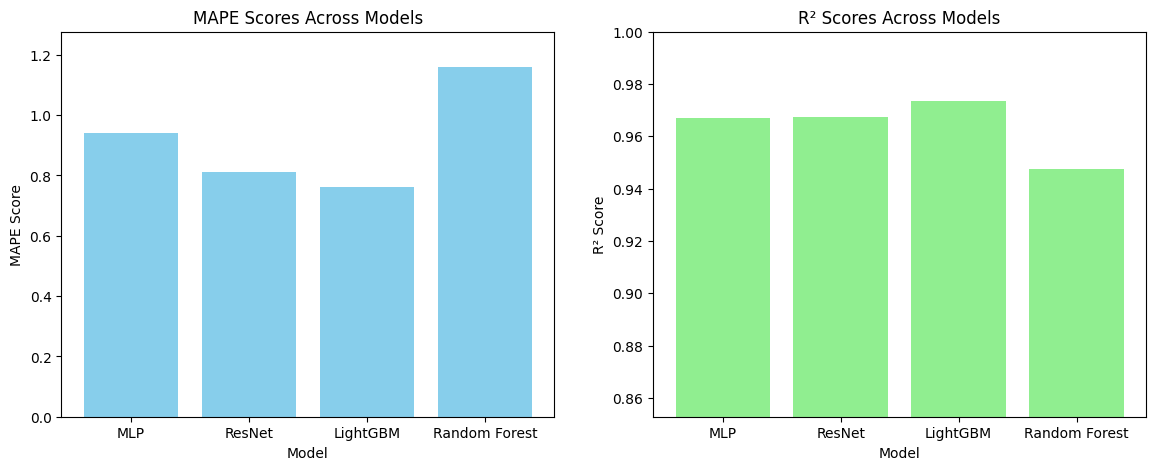

In [21]:
# Function to plot APE and R² Scores
def plot_performance(models, mape_scores, r2_scores):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart for MAPE scores
    ax[0].bar(models, mape_scores, color='skyblue')
    ax[0].set_title('MAPE Scores Across Models')
    ax[0].set_ylabel('MAPE Score')
    ax[0].set_xlabel('Model')
    ax[0].set_ylim([0, max(mape_scores) * 1.1])

    # Bar chart for R² scores
    ax[1].bar(models, r2_scores, color='lightgreen')
    ax[1].set_title('R² Scores Across Models')
    ax[1].set_ylabel('R² Score')
    ax[1].set_xlabel('Model')
    ax[1].set_ylim([min(r2_scores) * 0.9, 1])

    plt.show()

# Model names
models = ['MLP', 'ResNet', 'LightGBM', 'Random Forest']

# Storing MAPE and R² Scores
mape_scores = [mlp_mape, resnet_mape, lgbm_mape, rf_mape]
r2_scores = [mlp_r2, resnet_r2, lgbm_r2, rf_r2]

# Plotting performance comparison
plot_performance(models, mape_scores, r2_scores)


In [ ]:
Graph to visualize to compare the scatter plots of Predictions and Actual values. This can help to determine how close the predictions are to actual values

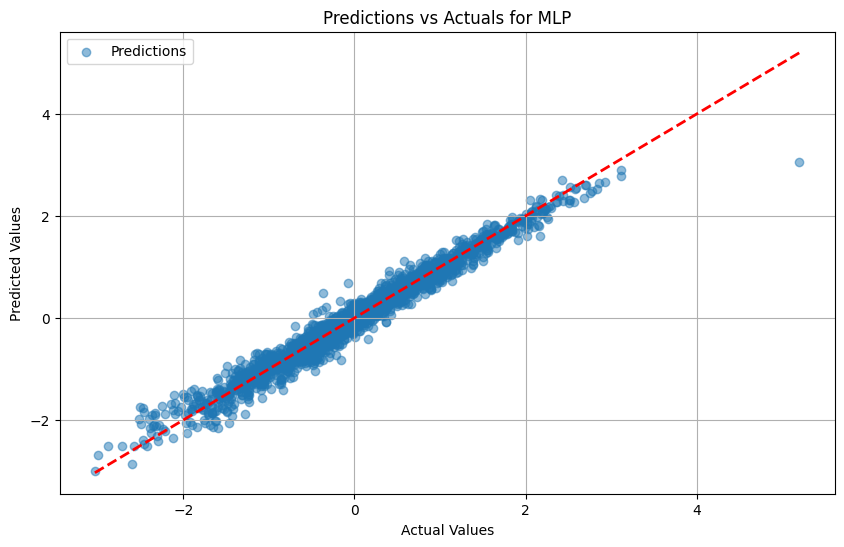

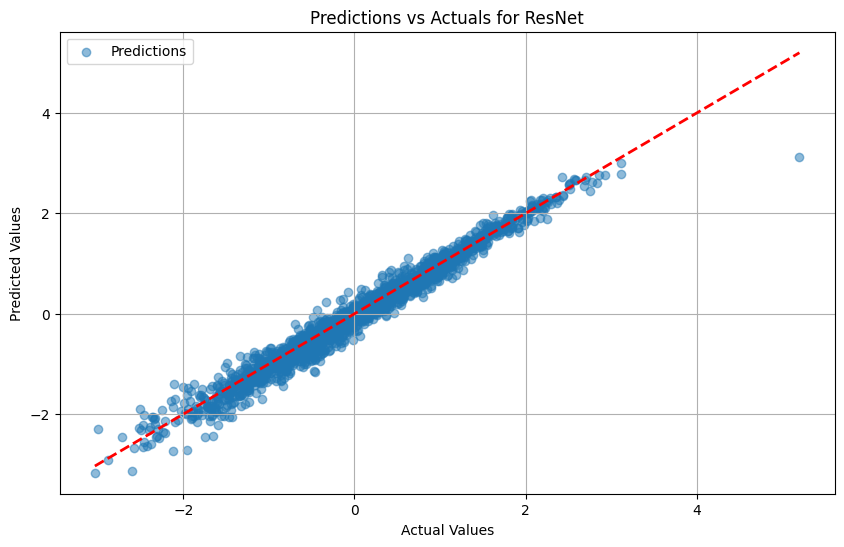

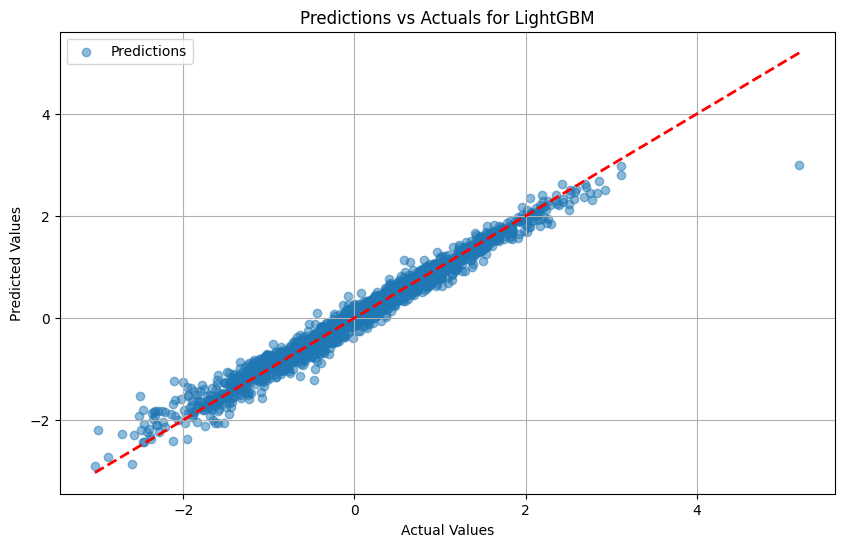

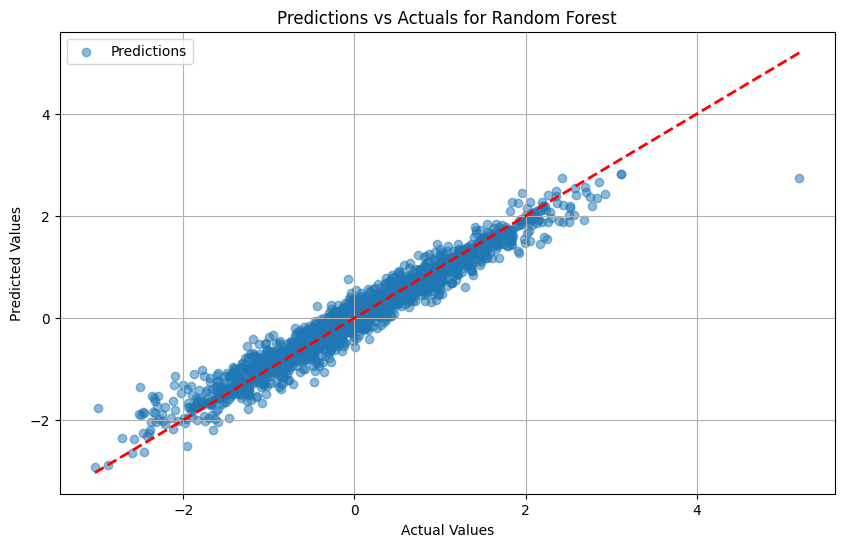

In [22]:
def plot_predictions_vs_actuals(actuals, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5, label='Predictions')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)  # Line for perfect prediction
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actuals for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting predictions vs actuals for each model
plot_predictions_vs_actuals(y_val, y_pred_mlp, 'MLP')
plot_predictions_vs_actuals(y_val, y_pred_resnet, 'ResNet')
plot_predictions_vs_actuals(y_val, y_pred_lgbm, 'LightGBM')
plot_predictions_vs_actuals(y_val, y_pred_rf, 'Random Forest')